In [43]:
library(tidypopgen)
library(admixtools)
library(ggplot2)
library(plotly)
#install.packages("vcfR")



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [4]:
modern_gt <- tidypopgen::gen_tibble("./data/modern_samples.bed",
                        valid_alleles = c("A","T","C","G"),
                        missing_alleles = c("X"))


gen_tibble saved to /home/dhawanjewar/EMBO_popgen24/Day5/data/modern_samples.gt

using bigSNP file: /home/dhawanjewar/EMBO_popgen24/Day5/data/modern_samples.rds

with backing file: /home/dhawanjewar/EMBO_popgen24/Day5/data/modern_samples.bk

make sure that you do NOT delete those files!

to reload the gen_tibble in another session, use gt_load('/home/dhawanjewar/EMBO_popgen24/Day5/data/modern_samples.gt')



Get a tally of the number of individuals per population

In [5]:
modern_gt %>% group_by(population) %>% tally()

population,n
<chr>,<int>
AA,12
Basque,29
Bedouin2,19
Cypriot,8
Dinka,7
Druze,39
French,25
Han,33
Mayan,18


## Perform QC on the data (check for missingness)
- Be more stringent on the modern data
- Be more relaxed on the ancient data

### Perform QC on modern data

In [6]:
modern_gt <- modern_gt %>%
select_loci_if(loci_missingness(genotypes)<0.04)

### Perform QC on ancient data

In [9]:
ancient_gt <- tidypopgen::gen_tibble("./data/ancient_samples.vcf",
                          valid_alleles = c("A","T","C","G","X"),
                          quiet = TRUE)

In [10]:
ancient_gt$id[ancient_gt$id == "GB20"] <- "Mota"

Assign populations to samples, currently using ids as population samples

In [11]:
ancient_gt$population <- ancient_gt$id

Merge data from ancient and modern samples

In [12]:
merged_dry <- rbind_dry_run(modern_gt, ancient_gt,
                            flip_strand = TRUE)

harmonising loci between two datasets
flip_strand =  TRUE  ; remove_ambiguous =  TRUE 
-----------------------------
dataset: reference 
number of SNPs: 581472 reduced to 581472 
( 0 are ambiguous, of which 0  were removed)
-----------------------------
dataset: target 
number of SNPs: 588768 reduced to 581472 
( 0 were flipped to match the reference set)
( 0 are ambiguous, of which 0 were removed)

Merge and save to file

In [14]:
merged_gt <- rbind(modern_gt, ancient_gt,
                    flip_strand = TRUE,
                    backingfile = "./data/merged_samples")

harmonising loci between two datasets
flip_strand =  TRUE  ; remove_ambiguous =  TRUE 
-----------------------------
dataset: reference 
number of SNPs: 581472 reduced to 581472 
( 0 are ambiguous, of which 0  were removed)
-----------------------------
dataset: target 
number of SNPs: 588768 reduced to 581472 
( 0 were flipped to match the reference set)
( 0 are ambiguous, of which 0 were removed)


gen_tibble saved to /home/dhawanjewar/EMBO_popgen24/Day5/data/merged_samples.gt

using bigSNP file: /home/dhawanjewar/EMBO_popgen24/Day5/data/merged_samples.rds

with backing file: /home/dhawanjewar/EMBO_popgen24/Day5/data/merged_samples.bk

make sure that you do NOT delete those files!

to reload the gen_tibble in another session, use gt_load('/home/dhawanjewar/EMBO_popgen24/Day5/data/merged_samples.gt')



Calculate pairwise f2 statistics and save to file to be used downstream

In [15]:
# group test_gt by population
merged_gt <- merged_gt %>% group_by(population)

f2_dir <- "./data/f2_tidypopgen"

# compute f2
f2_tidypopgen <- gt_extract_f2(merged_gt,
                                outdir = "./data/f2_tidypopgen",
                                overwrite = TRUE)

202754 SNPs remain after filtering. 191339 are polymorphic.




ℹ Allele frequency matrix for 202754 SNPs and 30 populations is 63 MB
ℹ Computing pairwise f2 for all SNPs and population pairs requires 3796 MB RAM without splitting
ℹ Computing without splitting since 3796 < 8000 (maxmem)...


Data written to ./data/f2_tidypopgen/




Read pre-computed f2 statistics

In [16]:
f2_blocks = f2_from_precomp("./data/f2_tidypopgen")

ℹ Reading precomputed data for 30 populations...
ℹ Reading f2 data for pair 465 out of 465...


We now have a mystery sample and just want to know what is the closest population from a panel of already characterised populations.
We will use a Neolithic sample from the Linear Band Keramik culture, called LBK. We will use a set of contemporary populations from western
Eurasia in our dataset.

In [17]:
# Western Eurasian
lbk_modern_panel <- c("Basque", "Bedouin2", "Druze", "Cypriot", "Tuscan",
                      "Sardinian", "French", "Spanish", "Onge", "Han", 
                      "Mayan", "Mixe", "Surui")

Compute outgroup $f_{3}$ using Mbuti as outgroup

In [18]:
lbk_f3out <- f3(data = f2_blocks,
                pop1 = "Mbuti",
                pop2 = "LBK",
                pop3 = lbk_modern_panel)

# Arrange by f3 estimates in descending order
lbk_f3out %>% arrange(desc(est))

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,LBK,Sardinian,0.06383625,0.0005520237,115.64042,0
Mbuti,LBK,Basque,0.06291524,0.0005458171,115.26799,0
Mbuti,LBK,Tuscan,0.06256139,0.0005440091,115.00063,0
Mbuti,LBK,French,0.06235083,0.0005408994,115.27250,0
Mbuti,LBK,Spanish,0.06212387,0.0005330377,116.54685,0
Mbuti,LBK,Cypriot,0.06136867,0.0005372127,114.23534,0
Mbuti,LBK,Druze,0.06046716,0.0005267235,114.79867,0
Mbuti,LBK,Bedouin2,0.05833366,0.0005210942,111.94456,0
Mbuti,LBK,Surui,0.05326572,0.0006675080,79.79787,0


## Q: Which populations share the most drift with LBK? (Plot ordered by level of shared drift)

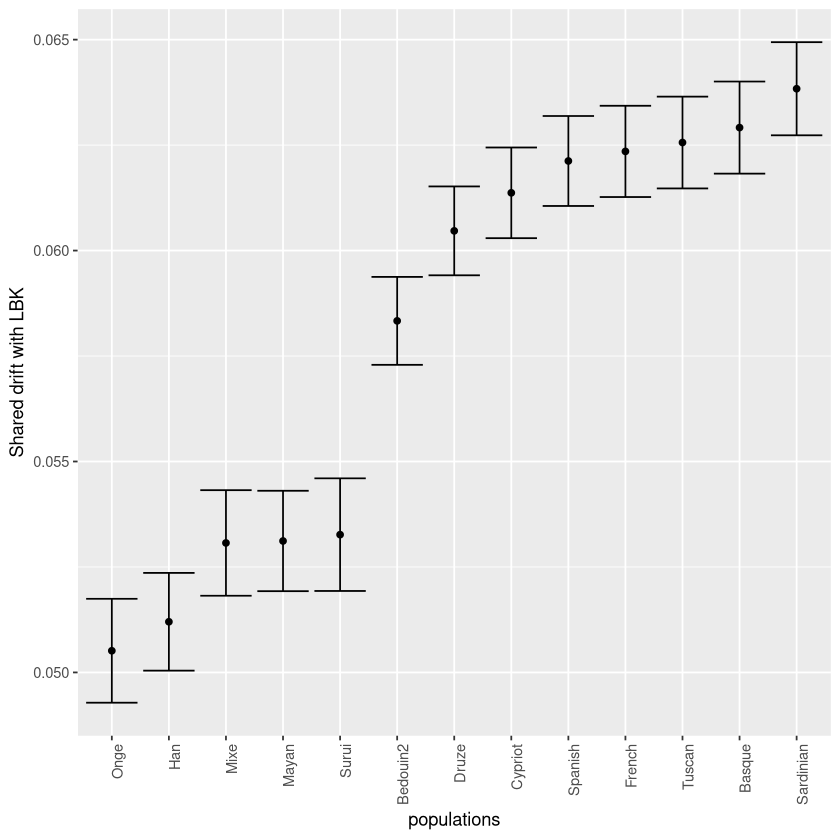

In [19]:
lbk_f3out$pop3<-factor(lbk_f3out$pop3, levels = lbk_f3out$pop3[order(lbk_f3out$est)])

ggplot(lbk_f3out, aes(pop3, est)) +
    geom_point() +
    geom_errorbar(aes(ymin = est - 2 * se, ymax = est + 2 * se)) +
    labs(y = "Shared drift with LBK", x = "populations") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Q: Investigate the relationship of the sample "MA1" (from Central Asia) with the contemporary samples

In [21]:
# Using the same modern panel for MA1 as LBK (Western Eurasia)
ma1_modern_panel <- lbk_modern_panel

# Using Mbuti as the outgroup
ma1_f3out <- f3(data = f2_blocks,
                pop1 = "Mbuti",
                pop2 = "MA1",
                pop3 = ma1_modern_panel)

# Arrange by f3 estimates in descending order
ma1_f3out %>% arrange(desc(est))

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,MA1,Surui,0.06178498,0.0007749173,79.73106,0
Mbuti,MA1,Mixe,0.06170624,0.0007180994,85.92994,0
Mbuti,MA1,Mayan,0.06082375,0.0006851560,88.77357,0
Mbuti,MA1,French,0.05809632,0.0005906329,98.36282,0
Mbuti,MA1,Basque,0.05790964,0.0005989540,96.68462,0
Mbuti,MA1,Spanish,0.05689009,0.0005846894,97.29968,0
Mbuti,MA1,Tuscan,0.05685658,0.0005997796,94.79578,0
Mbuti,MA1,Sardinian,0.05606215,0.0005957576,94.10227,0
Mbuti,MA1,Cypriot,0.05551302,0.0005960841,93.12950,0


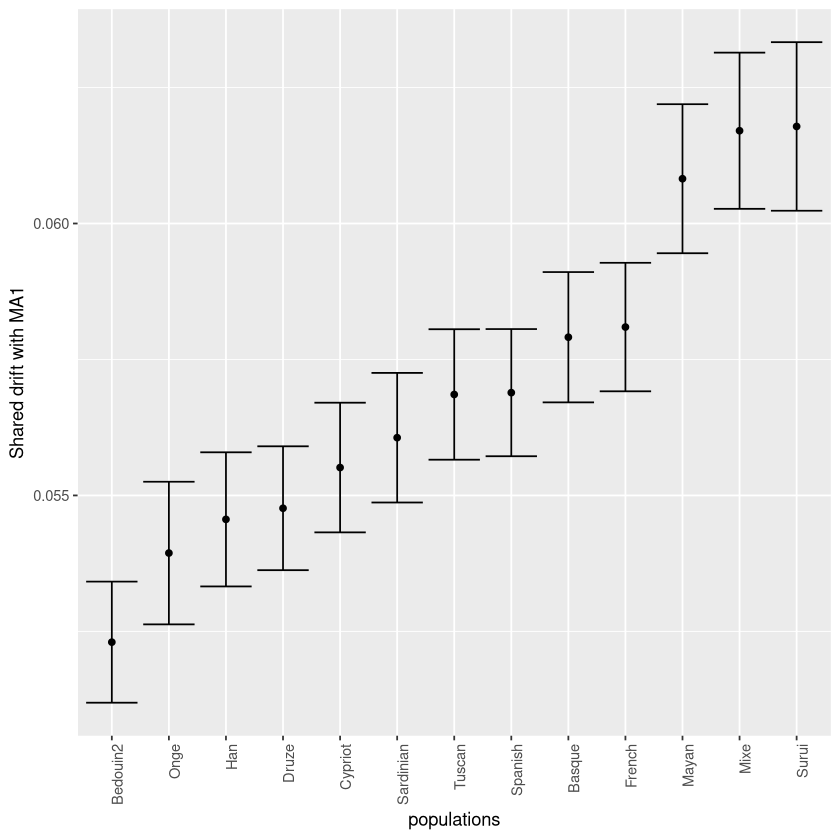

In [22]:
ma1_f3out$pop3<-factor(ma1_f3out$pop3, levels = ma1_f3out$pop3[order(ma1_f3out$est)])

ggplot(ma1_f3out, aes(pop3, est)) +
    geom_point() +
    geom_errorbar(aes(ymin = est - 2 * se, ymax = est + 2 * se)) +
    labs(y = "Shared drift with MA1", x = "populations") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

Do we have evidence for admixture?
Can African Americans be modelled as a mixture of African and European populations?

In [23]:
aa_f3admix <- f3(data = f2_blocks,
                    pop1 = "AA",
                    pop2 = "Yoruba",
                    pop3 = "French")

aa_f3admix

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AA,Yoruba,French,-0.0047181,0.0001196604,-39.42909,0


Since the f3 value is negative, we can infer that there was admixture between the African and European populations.

Test admixture in two East African target populations (Somali from Somalia, Dinka from Sudan)

In [26]:
eurasian_sources <- c("French","Spanish","Sardinian","LBK")

In [27]:
somali_f3admix <- f3(data = f2_blocks,
                    pop1 = "Somali",
                    pop2 = eurasian_sources,
                    pop3 = "Mota")

somali_f3admix

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Somali,French,Mota,-0.004564529,0.0002191228,-20.83092,2.270666e-96
Somali,LBK,Mota,-0.005111896,0.0003530471,-14.47936,1.636124e-47
Somali,Sardinian,Mota,-0.004952821,0.0002162430,-22.90397,4.242046e-116
Somali,Spanish,Mota,-0.004504032,0.0002071385,-21.74406,7.862117e-105


In [28]:
dinka_f3admix <- f3(data = f2_blocks,
                    pop1 = "Dinka",
                    pop2 = eurasian_sources,
                    pop3 = "Mota")

dinka_f3admix

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Dinka,French,Mota,0.006055945,0.0002917728,20.75569,1.089171e-95
Dinka,LBK,Mota,0.006151451,0.0004001492,15.37289,2.488035e-53
Dinka,Sardinian,Mota,0.006109395,0.0002939580,20.78323,6.139190e-96
Dinka,Spanish,Mota,0.006133083,0.0002860547,21.44024,5.631898e-102


Since the $f_{3}$ is positive, we can't conclude whether an admixture event happened that led to the Dinka populations

In [29]:
neand_french_f4 <- f4(data = f2_blocks,
                        pop1 = "pan_troglodytes",
                        pop2 = "AltaiNea",
                        pop3 = "Mbuti",
                        pop4 = "French")
                        
neand_french_f4

pop1,pop2,pop3,pop4,est,se,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pan_troglodytes,AltaiNea,Mbuti,French,0.001475259,0.0003281996,4.495008,6.956749e-06


In [30]:
neand_han_f4 <- f4(data = f2_blocks,
                        pop1 = "pan_troglodytes",
                        pop2 = "AltaiNea",
                        pop3 = "Mbuti",
                        pop4 = "Han")
                        
neand_han_f4

pop1,pop2,pop3,pop4,est,se,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pan_troglodytes,AltaiNea,Mbuti,Han,0.00178732,0.000351398,5.086312,3.650929e-07


qpWaves allows us to estimate the lower bound of the number of waves that have gone from the right to left populations.

Testing for the possibility of hybridization between archaic hominins and European modern populations

In [32]:
neand_euras_wave <- qpwave(data = f2_blocks,
                            left = c("French","Spanish","Tuscan"),
                            right = c("AltaiNea","Mota", "Yoruba", "Denisova", "Mbuti")
                    )

neand_euras_wave

ℹ Computing f4 stats...
ℹ Computing number of admixture waves...


$f4
# A tibble: 8 × 8
  pop1   pop2    pop3     pop4           est        se      z      p
  <chr>  <chr>   <chr>    <chr>        <dbl>     <dbl>  <dbl>  <dbl>
1 French Spanish AltaiNea Mota     0.000206  0.000101  2.05   0.0403
2 French Spanish AltaiNea Yoruba   0.000200  0.0000826 2.42   0.0155
3 French Spanish AltaiNea Denisova 0.000129  0.0000622 2.07   0.0387
4 French Spanish AltaiNea Mbuti    0.000136  0.0000793 1.71   0.0873
5 French Tuscan  AltaiNea Mota     0.000212  0.000178  1.19   0.235 
6 French Tuscan  AltaiNea Yoruba   0.000123  0.000140  0.883  0.377 
7 French Tuscan  AltaiNea Denisova 0.0000901 0.000102  0.884  0.377 
8 French Tuscan  AltaiNea Mbuti    0.0000110 0.000140  0.0784 0.937 

$rankdrop
# A tibble: 2 × 7
  f4rank   dof chisq     p dofdiff chisqdiff p_nested
   <int> <int> <dbl> <dbl>   <int>     <dbl>    <dbl>
1      1     3  2.00 0.573       5      9.27   0.0986
2      0     8 11.3  0.187      NA     NA     NA

In [33]:
neand_euras_wave <- qpwave(data = f2_blocks,
                            left = c("French","Spanish","Tuscan", "Han", "Onge"),
                            right = c("AltaiNea","Mota", "Yoruba", "Denisova", "Mbuti")
                    )

neand_euras_wave

ℹ Computing f4 stats...
ℹ Computing number of admixture waves...


pop1,pop2,pop3,pop4,est,se,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
French,Spanish,AltaiNea,Mota,2.061491e-04,1.005116e-04,2.05099758,0.040267183
French,Spanish,AltaiNea,Yoruba,1.999016e-04,8.256941e-05,2.42101280,0.015477332
French,Spanish,AltaiNea,Denisova,1.286687e-04,6.223346e-05,2.06751728,0.038685438
French,Spanish,AltaiNea,Mbuti,1.356078e-04,7.930945e-05,1.70985682,0.087292353
French,Tuscan,AltaiNea,Mota,2.119250e-04,1.782797e-04,1.18872201,0.234549077
French,Tuscan,AltaiNea,Yoruba,1.233836e-04,1.397507e-04,0.88288330,0.377299328
French,Tuscan,AltaiNea,Denisova,9.013837e-05,1.019779e-04,0.88390066,0.376749842
French,Tuscan,AltaiNea,Mbuti,1.096751e-05,1.398140e-04,0.07844359,0.937475198
French,Han,AltaiNea,Mota,-6.234677e-04,3.500173e-04,-1.78124807,0.074871934


Estimating proportion of admixture

In [36]:
french_adm <- qpadm(data = f2_blocks,
                    left = c("Loschbour", "LBK", "Yamnaya"),
                    right = c("Mbuti", "Mota", "Dinka", "Yoruba", "Han"),
                    target= "French")

french_adm$popdrop

ℹ Computing f4 stats...
ℹ Computing admixture weights...
ℹ Computing standard errors...
ℹ Computing number of admixture waves...


pat,wt,dof,chisq,p,f4rank,Loschbour,LBK,Yamnaya,feasible,best,dofdiff,chisqdiff,p_nested
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
000,0,2,5.638671,0.0596455703,2,-0.3861933,0.1612197,1.2249736,FALSE,NA,NA,NA,NA
001,1,3,7.480266,0.0580676721,1,0.5358352,0.4641648,NA,TRUE,TRUE,0,1.6457562,0
010,1,3,5.834510,0.1199452119,1,-0.8282722,NA,1.8282722,FALSE,TRUE,0,-0.3734753,1
100,1,3,6.207985,0.1019182842,1,NA,0.2712389,0.7287611,TRUE,TRUE,NA,NA,NA
011,2,4,15.027899,0.0046437011,0,1.0000000,NA,NA,TRUE,NA,NA,NA,NA
101,2,4,18.669740,0.0009124781,0,NA,1.0000000,NA,TRUE,NA,NA,NA,NA
110,2,4,10.522204,0.0324925054,0,NA,NA,1.0000000,TRUE,NA,NA,NA,NA


In [37]:
basque_adm <- qpadm(data = f2_blocks,
                    left = c("Loschbour", "LBK", "Yamnaya"),
                    right = c("Mbuti", "Mota", "Dinka", "Yoruba", "Han"),
                    target= "Basque")

basque_adm$popdrop

ℹ Computing f4 stats...
ℹ Computing admixture weights...
ℹ Computing standard errors...
ℹ Computing number of admixture waves...


pat,wt,dof,chisq,p,f4rank,Loschbour,LBK,Yamnaya,feasible,best,dofdiff,chisqdiff,p_nested
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
000,0,2,3.627023,0.163080489,2,-0.03828894,0.3428343,0.6954547,FALSE,NA,NA,NA,NA
001,1,3,6.466376,0.090998015,1,0.45306262,0.5469374,NA,TRUE,TRUE,0,1.257792,0
010,1,3,5.208585,0.157145407,1,-0.86345966,NA,1.8634597,FALSE,TRUE,0,1.503297,0
100,1,3,3.705288,0.295096647,1,NA,0.3519784,0.6480216,TRUE,TRUE,NA,NA,NA
011,2,4,18.061662,0.001200319,0,1.00000000,NA,NA,TRUE,NA,NA,NA,NA
101,2,4,15.099246,0.004499739,0,NA,1.0000000,NA,TRUE,NA,NA,NA,NA
110,2,4,11.252973,0.023863340,0,NA,NA,1.0000000,TRUE,NA,NA,NA,NA


from,to
R,Mbuti
R,eAfr
eAfr,Dinka
eAfr,outAfrica
outAfrica,Han
outAfrica,Loschbour


[1] TRUE

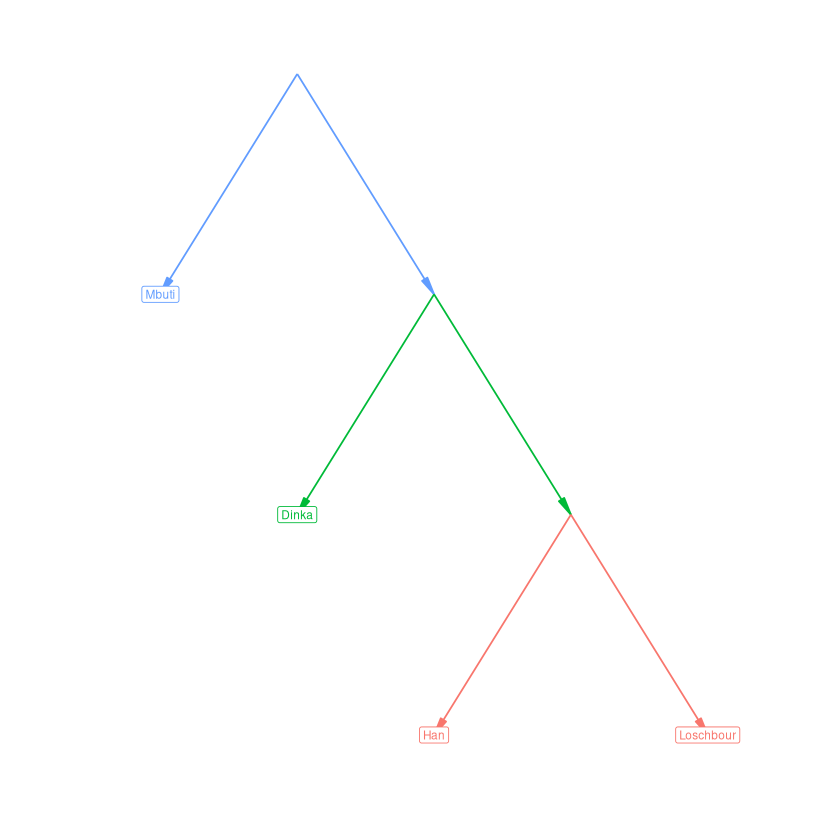

In [45]:
base_edges <- matrix(
                c("R", "Mbuti",
                  "R", "eAfr",
                  "eAfr", "Dinka",
                  "eAfr", "outAfrica",
                  "outAfrica", "Han",
                  "outAfrica", "Loschbour"),
                ncol=2,
                byrow = TRUE,
                dimnames=list(NULL, c("from","to")))

base_edges

base_igraph <- base_edges %>% edges_to_igraph()
is_valid(base_igraph)

# Static plot
base_igraph %>% plot_graph()

# Interactive plot
#base_igraph %>% plotly_graph()

In [47]:
base_qpgraph <- qpgraph(data = f2_blocks, graph = base_igraph)

base_qpgraph$f3

base_qpgraph$f3 %>% filter(abs(z)>2)

pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,Dinka,Dinka,0.02405428,0.0002952023,0.02405096,3.320856e-06,0.01124942,0.9910244
Mbuti,Dinka,Han,0.02175712,0.0003134527,0.02181393,-5.681144e-05,-0.18124406,0.8561760
Mbuti,Dinka,Loschbour,0.02196970,0.0003570995,0.02181393,1.557684e-04,0.43620439,0.6626884
Mbuti,Han,Han,0.07115365,0.0005367435,0.07122417,-7.052640e-05,-0.13139684,0.8954614
Mbuti,Han,Loschbour,0.05305283,0.0005883651,0.05299298,5.984967e-05,0.10172198,0.9189774
Mbuti,Loschbour,Loschbour,0.09123081,0.0012056983,0.09098259,2.482190e-04,0.20587159,0.8368912


pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


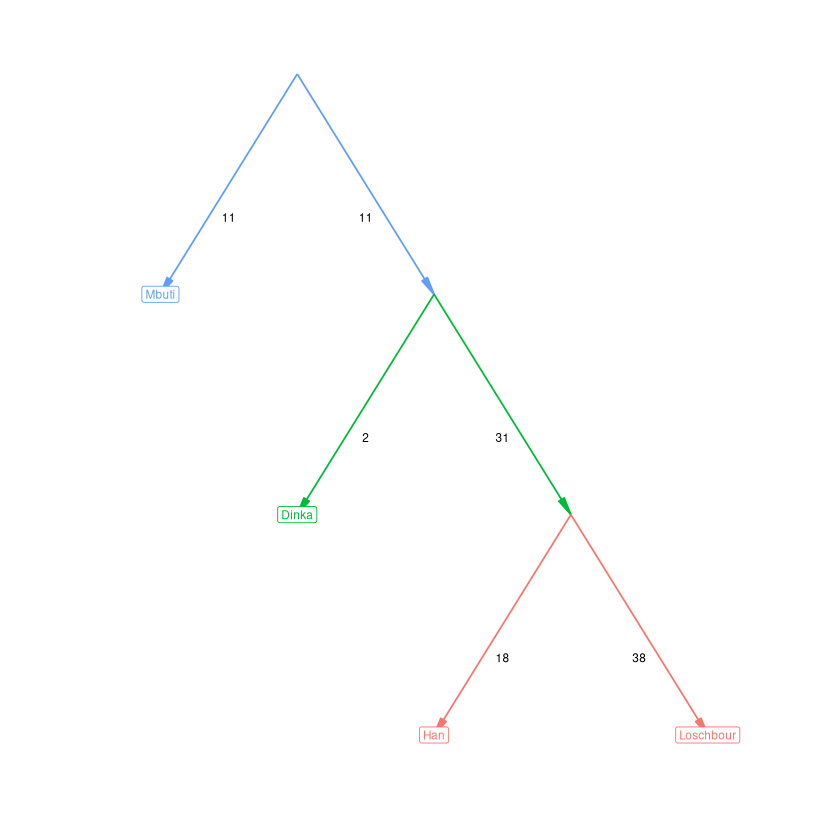

In [50]:
base_qpgraph$edges %>% plot_graph()

Choosing the wrong outgroup

from,to
R,Dinka
R,eAfr
eAfr,Mbuti
eAfr,outAfrica
outAfrica,Han
outAfrica,Loschbour


[1] TRUE

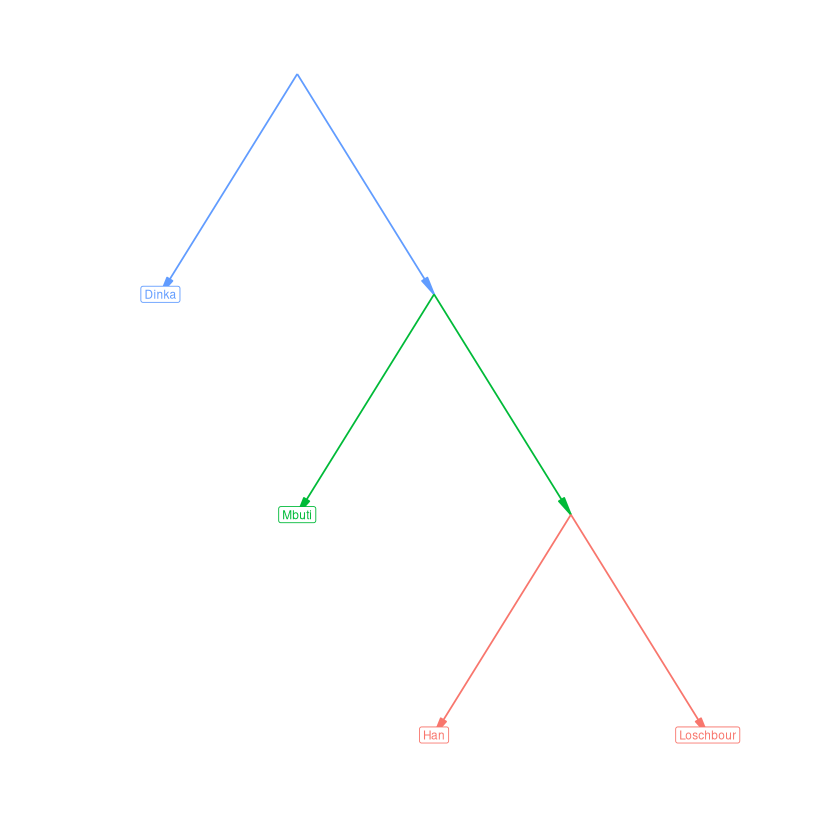

In [53]:
base_swapped_edges <- matrix(
                        c("R", "Dinka",
                          "R", "eAfr",
                          "eAfr", "Mbuti",
                          "eAfr", "outAfrica",
                          "outAfrica", "Han",
                          "outAfrica", "Loschbour"),
                        ncol=2,
                        byrow = TRUE,
                        dimnames=list(NULL, c("from","to")))

base_swapped_edges

base_swapped_igraph <- base_swapped_edges %>% edges_to_igraph()
is_valid(base_swapped_igraph)

# Static plot
base_swapped_igraph %>% plot_graph()

# Interactive plot
#base_igraph %>% plotly_graph()

In [54]:
base_swapped_qpgraph <- qpgraph(data = f2_blocks, graph = base_swapped_igraph)

base_swapped_qpgraph$f3

base_swapped_qpgraph$f3 %>% filter(abs(z)>2)

pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dinka,Mbuti,Mbuti,0.024054276,0.0002952023,0.024049783,4.492663e-06,0.01521893,0.9878575
Dinka,Mbuti,Han,0.002297153,0.0002131561,0.002237532,5.962052e-05,0.27970364,0.7797049
Dinka,Mbuti,Loschbour,0.002084573,0.0002699543,0.002237532,-1.529593e-04,-0.56661197,0.5709778
Dinka,Han,Han,0.051693677,0.0004530605,0.051647188,4.648966e-05,0.10261247,0.9182705
Dinka,Han,Loschbour,0.033380282,0.0004915479,0.033415595,-3.531297e-05,-0.07184035,0.9427290
Dinka,Loschbour,Loschbour,0.071345681,0.0011719758,0.071392403,-4.672208e-05,-0.03986608,0.9681999


pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


Compare the two models

In [55]:
fits = qpgraph_resample_multi(f2_blocks,
            graphlist = list(base_qpgraph[[1]], 
                             base_swapped_qpgraph[[1]]),
                             nboot = 100)

compare_fits(fits[[1]]$score_test, fits[[2]]$score_test)

0.06827826
-0.0947571


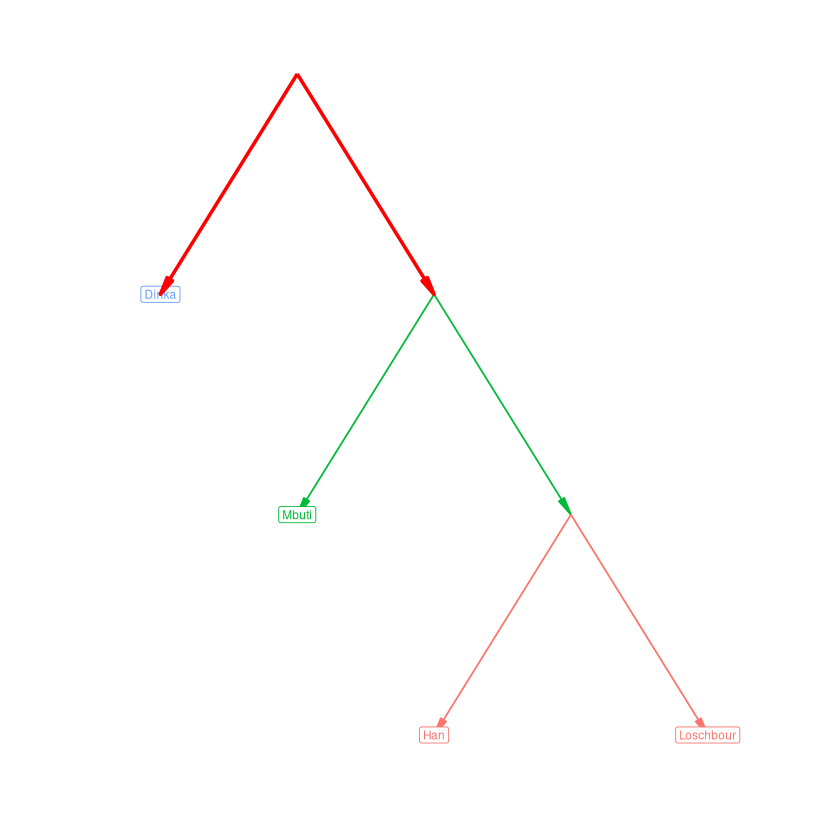

In [56]:
base_igraph %>% plot_graph(highlight_unidentifiable = TRUE)

[1] TRUE

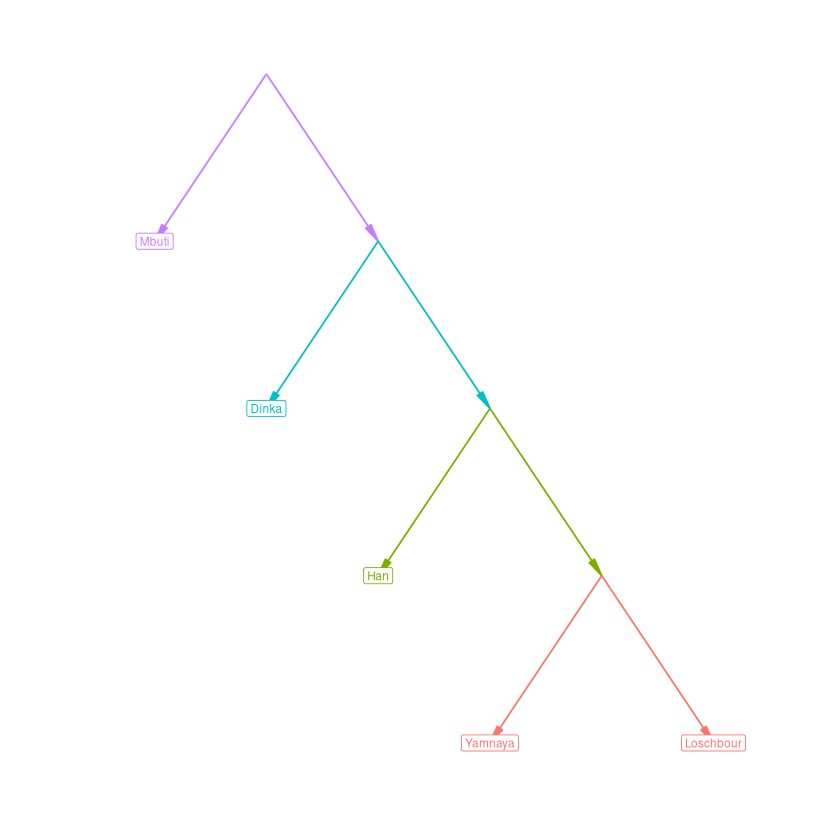

In [57]:
yamnaya_edges <- matrix(
                c("R", "Mbuti",
                  "R", "eAfr",
                  "eAfr", "Dinka",
                  "eAfr", "outAfrica",
                  "outAfrica", "Han",
                  "outAfrica", "wEurasian",
                  "wEurasian", "Yamnaya",
                  "wEurasian", "Loschbour"),
                ncol=2,
                byrow = TRUE,
                dimnames=list(NULL, c("from","to")))

yamnaya_igraph <- yamnaya_edges %>% edges_to_igraph()
is_valid(yamnaya_igraph)

# Static plot
yamnaya_igraph %>% plot_graph()


In [58]:
yamnaya_qpgraph <- qpgraph(data = f2_blocks, graph = yamnaya_igraph)

yamnaya_qpgraph$f3

yamnaya_qpgraph$f3 %>% filter(abs(z)>2)

pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,Dinka,Dinka,0.02405428,0.0002952023,0.02404789,6.383279e-06,0.02162340,0.9827484
Mbuti,Dinka,Han,0.02175712,0.0003134527,0.02175399,3.137069e-06,0.01000811,0.9920148
Mbuti,Dinka,Yamnaya,0.02166441,0.0003173342,0.02175399,-8.957472e-05,-0.28227247,0.7777346
Mbuti,Dinka,Loschbour,0.02196970,0.0003570995,0.02175399,2.157169e-04,0.60408057,0.5457901
Mbuti,Han,Han,0.07115365,0.0005367435,0.07112795,2.569915e-05,0.04787977,0.9618121
Mbuti,Han,Yamnaya,0.05262862,0.0005100894,0.05271653,-8.790976e-05,-0.17234188,0.8631688
Mbuti,Han,Loschbour,0.05305283,0.0005883651,0.05271653,3.362976e-04,0.57157978,0.5676067
Mbuti,Yamnaya,Yamnaya,0.07651678,0.0006380620,0.07669450,-1.777172e-04,-0.27852649,0.7806082
Mbuti,Yamnaya,Loschbour,0.06105874,0.0006192041,0.06091107,1.476767e-04,0.23849431,0.8114977


pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


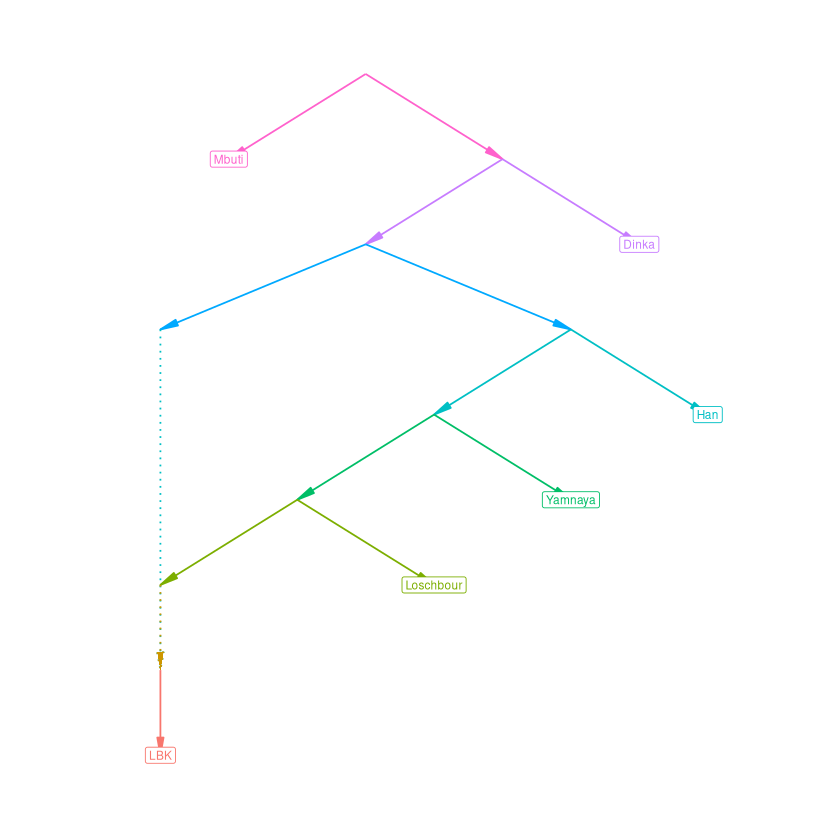

In [59]:
lbk_extra_edges <- matrix(
                    c(
                      "R", "Mbuti",
                      "R", "eAfr",
                      "eAfr", "pBasalEurasian",
                      "eAfr", "Dinka",
                      "pBasalEurasian", "BasalEurasian",
                      "pBasalEurasian","outAfrica",
                      "outAfrica", "Han",
                      "outAfrica","wEurasian",
                      "wEurasian", "Yamnaya",
                      "wEurasian", "pLoschbour",
                      "pLoschbour", "Loschbour",
                      "pLoschbour","WHG",
                      "BasalEurasian", "pLBK",
                      "WHG", "pLBK",
                      "pLBK","LBK"),
                    ncol = 2,
                    byrow = TRUE,
                    dimnames = list(NULL, c("from", "to")))


lbk_extra_igraph <- lbk_extra_edges %>% edges_to_igraph()

lbk_extra_igraph %>% plot_graph()

[1] TRUE

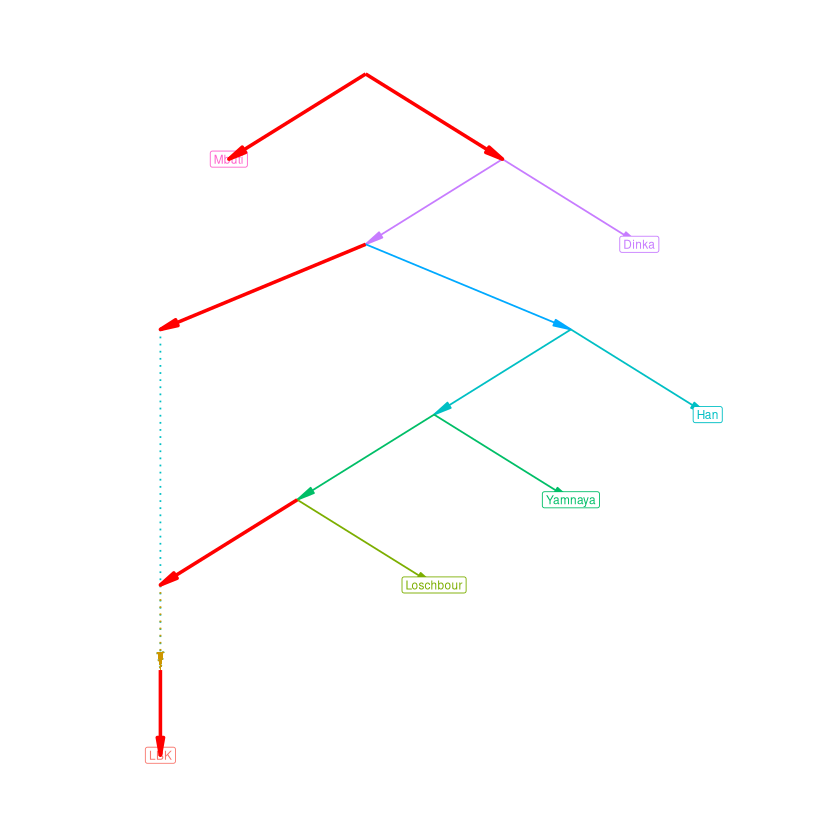

In [60]:
is_valid(lbk_extra_igraph)

lbk_extra_igraph %>% plot_graph(highlight_unidentifiable = TRUE)

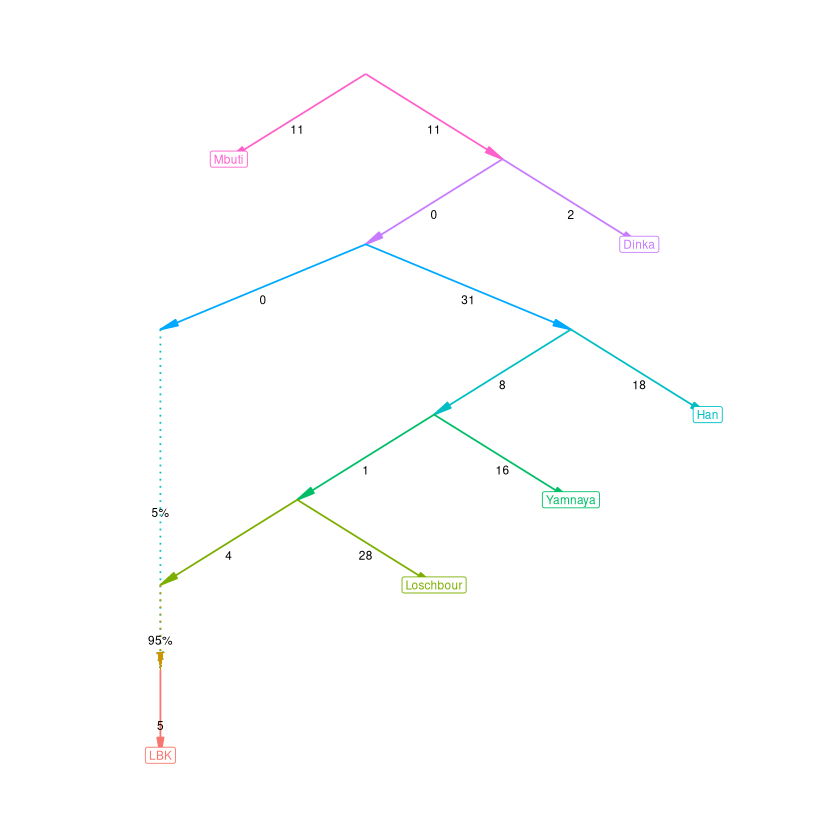

In [61]:
lbk_extra_qpgraph <- qpgraph(data = f2_blocks, graph = lbk_extra_igraph)
lbk_extra_qpgraph$edges %>% plot_graph()